# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [33]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [34]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [35]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu102


In [36]:
### different transformer models

from torchvision.models import resnet50

from vit_pytorch.distill import DistillableViT, DistillWrapper

teacher = resnet50(pretrained = True)

v = DistillableViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

distiller = DistillWrapper(
    student = v,
    teacher = teacher,
    temperature = 3,           # temperature of distillation
    alpha = 0.5,               # trade between main loss and distillation loss
    hard = False               # whether to use soft or hard distillation
)

### for demo/testing
img = torch.randn(2, 3, 256, 256)
labels = torch.randint(0, 1000, (2,))

loss = distiller(img, labels)
loss.backward()

# after lots of training above ...

pred = v(img) # (2, 1000)

print(pred)

tensor([[ 0.1520, -0.3618,  0.5642,  ...,  0.2835,  0.1005, -0.0436],
        [-0.2501, -1.0356,  0.2498,  ..., -0.1182,  0.0613,  0.0756]],
       grad_fn=<AddmmBackward>)


In [37]:
# Training settings
batch_size = 50
epochs = 10 ### for testing 
lr = 2e-4
gamma = 0.9
seed = 42

In [38]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [39]:
device = 'cuda'

## Load Data

In [40]:
### read csv from Song-Mao


train_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_train_46183_C5.csv")
test_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_test_15395_C5.csv")


#os.makedirs('../data', exist_ok=True)

In [41]:
test_df.tail()


train_dir = '/media/joshua/Milano/galaxy_zoo/train/'
test_dir = '/media/joshua/Milano/galaxy_zoo/test/'



In [42]:
train_df["GalaxyID"][0] == int(100008)

True

In [43]:
# with zipfile.ZipFile('../data/train.zip') as train_zip:
#     train_zip.extractall('data')
    
# with zipfile.ZipFile('../data/test.zip') as test_zip:
#     test_zip.extractall('data')

In [44]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [45]:
 
print(f"Test Data: {len(test_list)}")

Test Data: 15395


In [46]:
labels = train_df['label']


## Random Plots

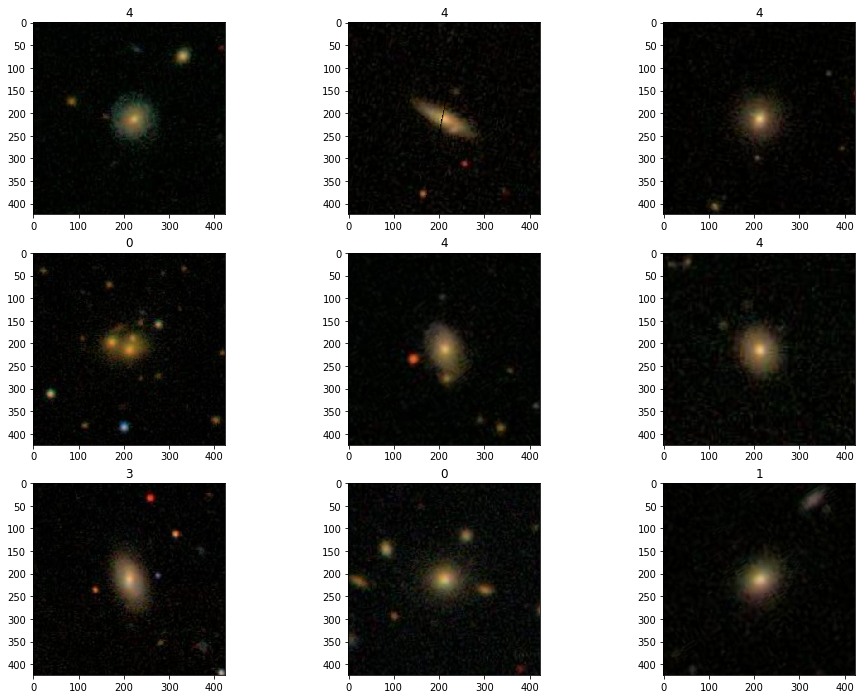

In [47]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [48]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          random_state=seed)

In [49]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 36946
Validation Data: 9237
Test Data: 15395


## Image Augumentation

In [50]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


## Load Datasets

In [51]:
class Galaxy_ZooDataset(Dataset):
    def __init__(self, file_list, transform=None, train=True, val=False, test=False):
        self.file_list = file_list
        self.transform = transform
        self.train = train
        self.val = val
        self.test = test
        self.train_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_train_46183_C5.csv")
        self.test_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_test_15395_C5.csv")


    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        ID = img_path.split("/")[-1].split(".")[0]
        ID = int(ID)
        #print("ID", ID)

        
        
        #print("image_path", img_path)
        if self.train or self.val:
            label = train_df[train_df['GalaxyID']==ID].label 
            #print(train_df[train_df['GalaxyID']==ID])
            
        else:
            label = test_df[test_df['GalaxyID']==ID].label 
        #print(label.values[0])
        label = int(label.values[0])

        return img_transformed, label


In [52]:
train_data = Galaxy_ZooDataset(train_list, transform=train_transforms, train=True, val=False, test=False)
valid_data = Galaxy_ZooDataset(valid_list, transform=test_transforms, train=False, val=True, test=False)
test_data = Galaxy_ZooDataset(test_list, transform=test_transforms, train=False, val=False, test=True)

In [53]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [54]:
print(len(train_data), len(train_loader))

36946 739


In [55]:
print(len(valid_data), len(valid_loader))

9237 185


## Effecient Attention

### Linformer

In [56]:
efficient_transformer = Linformer(
    dim=256,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [57]:
# model = ViT(
#     dim=256,
#     image_size=224,
#     patch_size=32,
#     num_classes=5,
#     transformer=efficient_transformer,
#     channels=3,
# ).to(device)

model = v.to(device)

### Training

In [58]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            #print("label", label)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )



Epoch : 1 - loss : 1.0151 - acc: 0.5901 - val_loss : 0.9672 - val_acc: 0.5986




Epoch : 2 - loss : 0.9607 - acc: 0.6043 - val_loss : 0.9471 - val_acc: 0.6092



In [ ]:
val_output = model(data)
val_output




In [ ]:
test_data[0][1]

In [ ]:
for idx in range(40):
    #img = Image.open(data[idx].cpu())
#     ax.set_title(labels[idx])
#     ax.imshow(test_data[idx])
    plt.imshow(valid_data[idx][0][0])
    #plt.title("label:", test_data[idx][1])
    plt.show()
    print(valid_data[idx][1])
    prediction_latent = model(valid_data[idx][0].unsqueeze(0).cuda())
    
    print("prediction", prediction_latent.argmax(dim=1))
    #print(valid_data[idx][0].shape)